# Catalogue Query Tools

This notebook provides examples on how to use the Catalogue Toolkit to build and explore a catalogue database:

In [7]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from openquake.cat.parsers.isf_catalogue_reader import ISFReader
from openquake.cat.parsers.converters import (GenericCataloguetoISFParser, GCMTtoISFParser)
from openquake.cat.isc_homogenisor import (HomogenisorPreprocessor,
                                   DynamicHomogenisor,
                                   MagnitudeConversionRule,
                                   DuplicateFinder)
import openquake.cat.catalogue_query_tools as cqt

import tempfile
import shutil

In [8]:
BASE_PATH = os.getcwd()
data_path = os.path.join(BASE_PATH, "reg-inputs")

temp_dir = tempfile.mkdtemp()

## Constructing the Database

In [9]:
# This merges multiple .isf files together

def append_isf_files(source_folder, output_file):
    '''  
    Append a series of .isf files that were downloaded from the ISC website.
    '''
    try:
        with open(output_file, 'w') as output:
            for filename in os.listdir(source_folder):
                if filename.endswith('.isf'):
                    file_path = os.path.join(source_folder, filename)
                    with open(file_path, 'r') as input_file:
                        content = input_file.read()
                        output.write(content + '\n')

        print("Content of text files appended together successfully.")
    except Exception as e:
        print("An error occurred:", str(e))

# Replace 'path_to_source_folder' with the actual path of the folder containing the text files.
source_folder = os.path.join(data_path, "isf")
output_file = os.path.join(BASE_PATH, "reg-outputs", "1900-2021-PH_ISF_Catalogue.isf")


append_isf_files(source_folder, output_file)

# move to temp_dir
shutil.move(output_file, temp_dir)
print("moved to Temporary directory:", temp_dir)

Content of text files appended together successfully.
moved to Temporary directory: C:\Users\Enrico\AppData\Local\Temp\tmpb9m58cjs


In [10]:
#ISC
isc_parser_1900_2021 = ISFReader(os.path.join(temp_dir, "1900-2021-PH_ISF_Catalogue.isf"),
                   selected_origin_agencies=["GCMT", "HRVD", "MAN", "QCP"],
                   selected_magnitude_agencies=["GCMT", "HRVD", "MAN", "QCP"])
isc_catalogue_1900_2021 = isc_parser_1900_2021.read_file("ISC-RB", "ISC-1900-2021")

print("ISC Catalogue 1900-2021 MAN, GCMT contains: %d events" % isc_catalogue_1900_2021.get_number_events())

ISC Catalogue 1900-2021 MAN, GCMT contains: 38150 events


In [11]:
# phivolcs
phivolcs_parser = GenericCataloguetoISFParser("reg-inputs/phivolcs-combined-hmtk-minM4pt5.csv")
phivolcs_catalogue = phivolcs_parser.parse("phivolcs", "phivolcs-CAT")
print("phivolcs Catalogue 2015-2023 contains: %d events" % phivolcs_catalogue.get_number_events())

#GCMT
GCMT_catalogue = GCMTtoISFParser("reg-inputs/gcmt-cat-1976-2020.txt").parse()
print("GCMT Catalogue 1976-2020 contains: %d events" % GCMT_catalogue.get_number_events())

phivolcs Catalogue 2015-2023 contains: 1861 events
Parsing catalogue ...
complete. Contains 56832 moment tensors
GCMT Catalogue 1976-2020 contains: 56832 events


In [12]:
print('merging gcmt and iscrb')
merge = DuplicateFinder(isc_catalogue_1900_2021, 60, 110, logging=True)
mergedCatalogue = merge.merge_catalogue(GCMT_catalogue)

print('merging with phivolcs')
merge1 = DuplicateFinder(mergedCatalogue, 60, 110, logging=True)
merged1Catalogue = merge1.merge_catalogue(phivolcs_catalogue)

merging gcmt and iscrb
After duplicate finding: 91365 events (91365)
merging with phivolcs
After duplicate finding: 92096 events (92096)


In [13]:
origin_isc_df, magnitude_isc_df = merged1Catalogue .build_dataframe()
origin_isc_df

C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713435)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713499)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713713)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713911)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:714586)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:714589)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\

,eventID,originID,Agency,year,month,day,hour,minute,second,time_error,...,semiminor90,error_strike,depth_error,prime,dip1,rake1,str1,dip2,rake2,str2
0,893386,1930704,MAN,1952,9,10,18,47,7.000000,0.0,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,855394,05243025,GCMT,1965,7,15,18,33,34.500000,0.7,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,853881,05243317,GCMT,1965,9,16,13,50,10.796875,1.3,...,0.0,0.0,6.2,1,0.0,0.0,0.0,0.0,0.0,0.0
3,853357,05243323,GCMT,1965,10,24,14,32,15.398438,1.0,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
4,792982,05243111,GCMT,1970,8,18,16,52,31.796875,1.3,...,0.0,0.0,11.7,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155193,61283344,61283344,phivolcs,2023,7,23,6,2,53.000000,0.0,...,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
155194,61283300,61283300,phivolcs,2023,7,25,1,0,41.000000,0.0,...,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
155195,61283288,61283288,phivolcs,2023,7,25,15,35,8.000000,0.0,...,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
155196,61283262,61283262,phivolcs,2023,7,26,17,47,59.000000,0.0,...,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Build the HDF5 Database
database_file_isc_gcmt_phivolcs= "reg-outputs/isc-gcmt-phivolcs_db1.hdf5"
if os.path.exists(database_file_isc_gcmt_phivolcs):
    os.remove(database_file_isc_gcmt_phivolcs)
_ = merged1Catalogue.build_dataframe(hdf5_file=database_file_isc_gcmt_phivolcs)

# # Build the HDF5 Database
# database_file_phivolcs = "reg-outputs/phivolcs_db1.hdf5"
# if os.path.exists(database_file_phivolcs):
#     os.remove(database_file_phivolcs)
# _ = phivolcs_catalogue.build_dataframe(hdf5_file=database_file_phivolcs)

C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713435)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713499)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713713)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:713911)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:714586)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\oq-mbtk\openquake\cat\isf_catalogue.py:1212: UserWarning: Warning, depth <= 0.0 (id:714589)
  warnings.warn(fmt.format(eq.id))
C:\Users\Enrico\Desktop\catalogue\

## Using the Database

In [15]:
# db_isc = cqt.CatalogueDB(database_file_isc)
# db_phivolcs = cqt.CatalogueDB(database_file_phivolcs)

db_isc_gcmt_phivolcs = cqt.CatalogueDB(database_file_isc_gcmt_phivolcs)

### Apply Limiting Selections

#### By Bounding Box

In [16]:
lower_lon = 15.
upper_lon = 30.
lower_lat = 30.
upper_lat = 45.
bbox = [lower_lon, upper_lon, lower_lat, upper_lat]
selector = cqt.CatalogueSelector(db1)
aegean_cat = selector.select_within_bounding_box(bbox)

NameError: name 'db1' is not defined

In [ ]:
number_origins, number_magnitudes = aegean_cat._get_number_origins_magnitudes()
print("Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes))

#### By Polygon

In [ ]:
polygon = np.array([[15.0, 45.0],
                    [30.0, 45.0],
                    [30.0, 30.0],
                    [15.0, 30.0],
                    [15.0, 45.0]])
selector2 = cqt.CatalogueSelector(db1)
aegean_cat_alt = selector2.select_within_polygon(polygon[:, 0], polygon[:, 1])
number_origins, number_magnitudes = aegean_cat_alt._get_number_origins_magnitudes()
print("Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes))

#### By Magnitude

In [ ]:
# Above magnitude 6.0
selector3 = cqt.CatalogueSelector(aegean_cat)
aegean_cat_m6 = selector3.select_within_magnitude_range(lower_mag=6.0, upper_mag=9.0)
number_origins, number_magnitudes = aegean_cat_m6._get_number_origins_magnitudes()
print("Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes))

#### By Depth

In [ ]:
selector4 = cqt.CatalogueSelector(aegean_cat_alt)
aegean_cat_deep = selector4.select_within_depth_range(upper_depth=50.0, lower_depth=200.0)
number_origins, number_magnitudes = aegean_cat_deep._get_number_origins_magnitudes()
print("Number of Origins = %d, Number of Magnitudes = %d" % (number_origins,
                                                             number_magnitudes))

## Exploring the Catalogue Database

### See Summary of Agencies and Magnitudes in the Catalogue

In [ ]:
agency_count = cqt.get_agency_magtype_statistics(db_isc_gcmt_phivolcs)

In [ ]:
agency_count_phivolcs = cqt.get_agency_magtype_statistics(db_isc_gcmt_phivolcs)

In [ ]:
origin_isc_df, magnitude_isc_df = merged1Catalogue.build_dataframe()
origin_isc_df

### Search for a Specific Agency-Magnitude Combination

Search for body-wave magnitude common to 'BJI' and 'ISC'

In [17]:
query_phivolcs_ms, phivolcs_ms_cat = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("phivolcs", "Ms"), ("GCMT", "Mw"), no_case=True)
# query_phivolcs_ms, phivolcs_ms_cat = cqt.get_agency_magnitude_pairs(db_isc_phivolcs, ("phivolcs", "ms"), ("phivolcs", "ms"), no_case=True)
# query_phivolcs_ms, phivolcs_ms_cat = cqt.get_agency_magnitude_pairs(db_isc_phivolcs, ("phivolcs", "ms"), ("ISC", "mb"), no_case=True)

Agency-Pairs: (phivolcs, Ms) & (GCMT, Mw) returned 704 events


In [18]:
bji_isc_mb_cat

NameError: name 'bji_isc_mb_cat' is not defined

In [ ]:
_ = cqt.plot_agency_magnitude_density(query_phivolcs_ms)

### Join Query Results

Join together the results of two queries. For example the Global CMT magnitudes are reported under either
'GCMT' or 'HRVD'. So search for both terms

In [19]:
query1, cat1 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("phivolcs", "Ms"), ("GCMT", "Mw"), no_case=True)
query2, cat2 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("phivolcs", "Ms"), ("HRVD", "Mw"), no_case=True)
query_phivolcs_ms = cqt.join_query_results(query1, query2)

query3, cat3 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("MAN", "Ms"), ("GCMT", "Mw"), no_case=True)
query4, cat4 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("MAN", "Ms"), ("HRVD", "Mw"), no_case=True)
query_MAN_ms = cqt.join_query_results(query1, query2)

query_PH_ms = cqt.join_query_results(query_phivolcs_ms, query_MAN_ms)

Agency-Pairs: (phivolcs, Ms) & (GCMT, Mw) returned 704 events
Agency-Pair: (HRVD, Mw) returned no magnitudes
Agency-Pairs: (MAN, Ms) & (GCMT, Mw) returned 2770 events
Agency-Pair: (HRVD, Mw) returned no magnitudes


In [20]:
type(query_phivolcs_ms)

collections.OrderedDict

In [21]:
query1, cat1 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("phivolcs", "Ms"), ("GCMT", "Mw"), no_case=True)
query2, cat2 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("MAN", "Ms"), ("GCMT", "Mw"), no_case=True)
query_phivolcs_ms = cqt.join_query_results(query1, query2)

Agency-Pairs: (phivolcs, Ms) & (GCMT, Mw) returned 704 events
Agency-Pairs: (MAN, Ms) & (GCMT, Mw) returned 2770 events


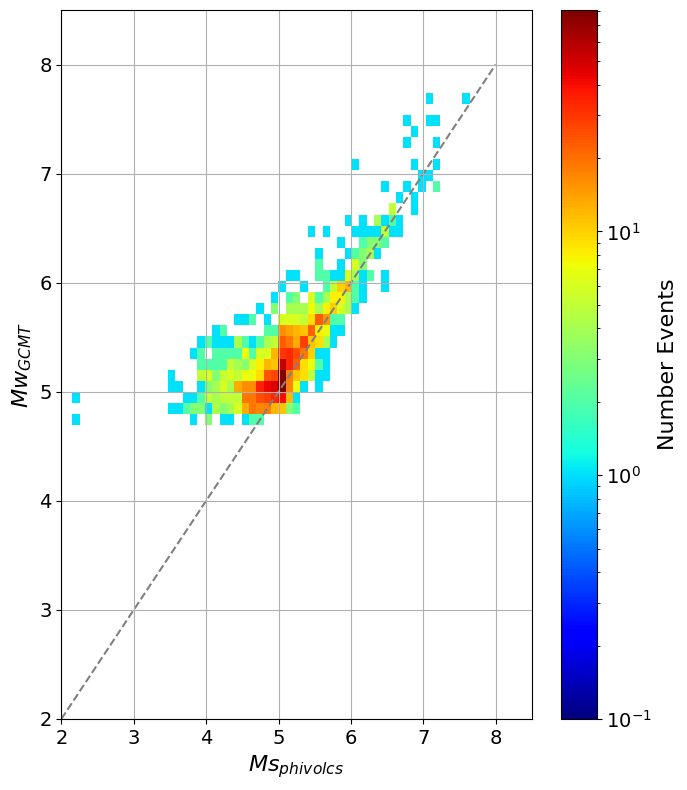

In [22]:
_ = cqt.plot_agency_magnitude_density(query_phivolcs_ms)

## Regression Tools

In this example we compare the $M_S$ scale as recorded by the BJI network with the $M_W$ scale reported by
HRVD/GCMT (from the previous query)

#### Set up the regression

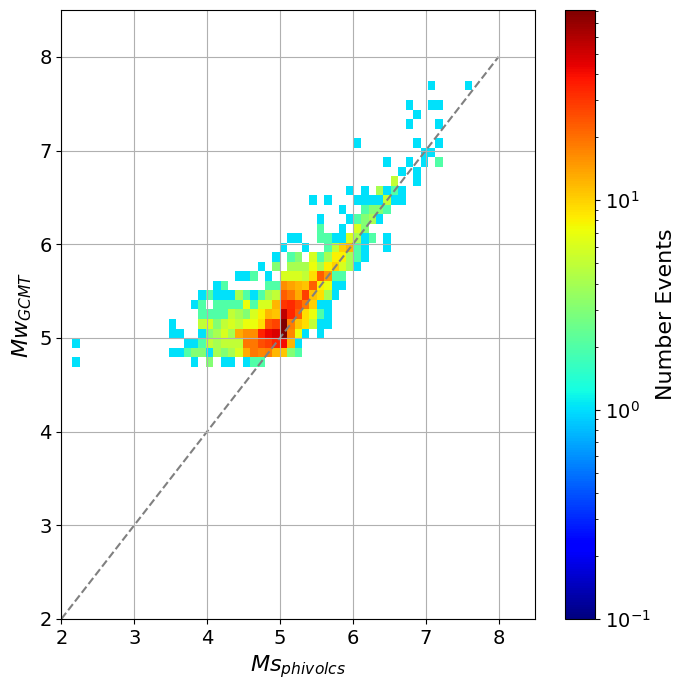

In [23]:
regressor = cqt.CatalogueRegressor(query_phivolcs_ms)
regressor.plot_density(overlay=False)

#### Apply a Linear Model 

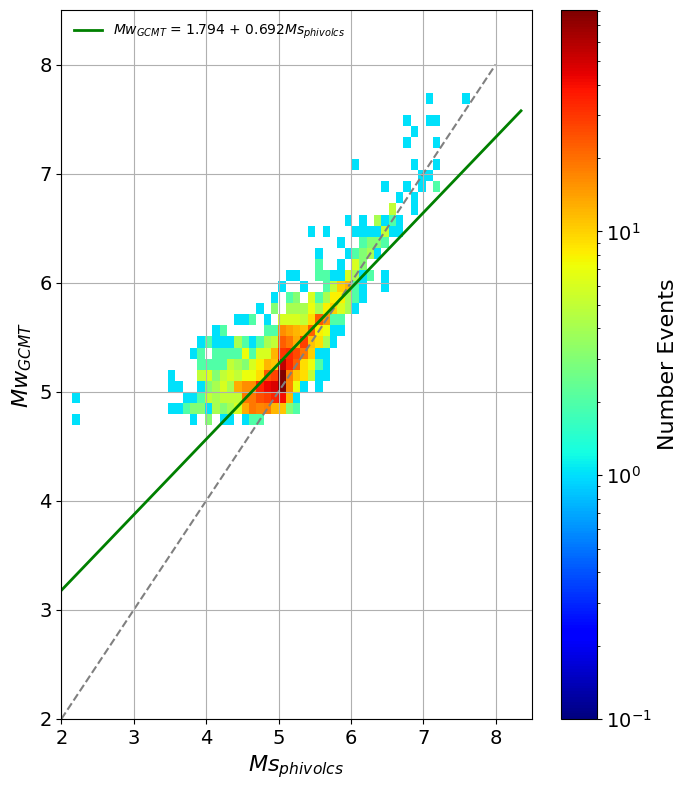

Mw = 1.794 + 0.692 MS +/- 0.260


In [24]:
linear_model = regressor.run_regression("polynomial", # Model Type
                                        [0., 2.]) # Initial guess of parameters
regressor.plot_model_density(False, 0)
# View Results
print("Mw = %.3f + %.3f MS +/- %.3f" % (regressor.results.beta[0],
                                        regressor.results.beta[1],
                                        regressor.standard_deviation))

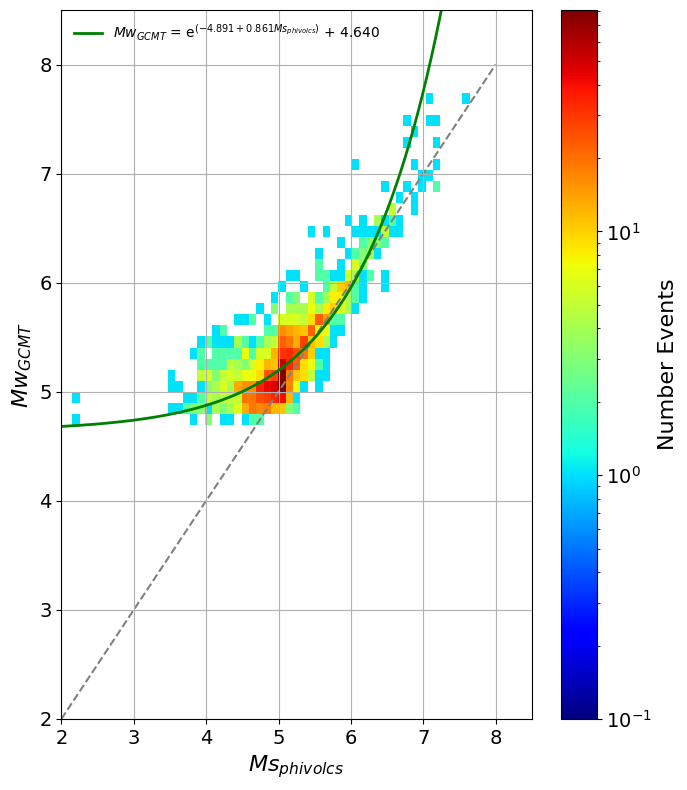

Mw = -4.891 + 0.861 MS +/- 0.227


In [25]:
linear_model = regressor.run_regression("exponential", # Model Type
                                        [1., 1., 1.]) # Initial guess of parameters
regressor.plot_model_density(False, 0)
# View Results
print("Mw = %.3f + %.3f MS +/- %.3f" % (regressor.results.beta[0],
                                        regressor.results.beta[1],
                                        regressor.standard_deviation))

#### Overlay another model defined as a Magnitude Conversion Rule

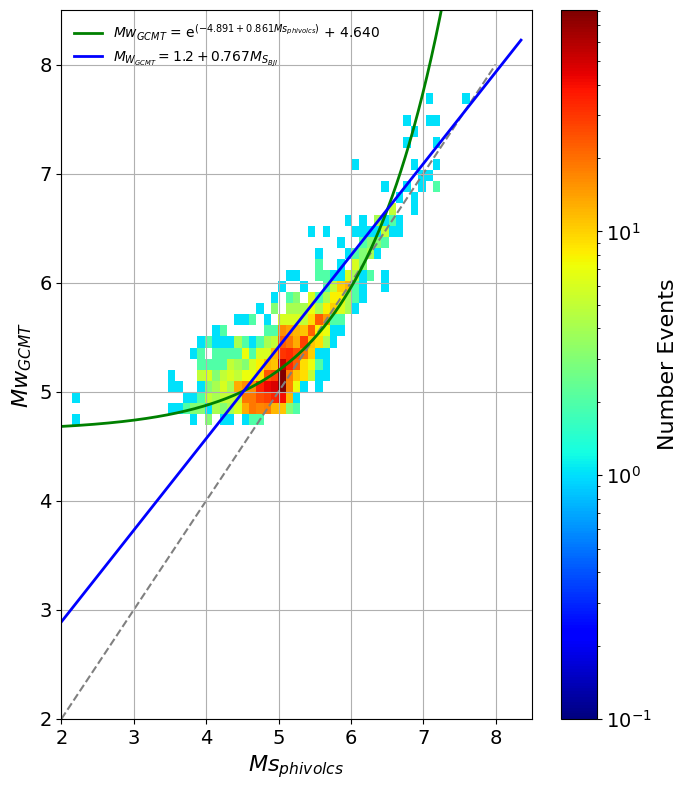

In [26]:
from openquake.cat.isc_homogenisor import MagnitudeConversionRule
# Define empirical model
def RandomRule1(magnitude):
    return 1.21 + 0.84 * magnitude

def RandomRuleSigma(magnitude):
    return 0.2
# Create Rule
rule1 = MagnitudeConversionRule("BJI", "MS", RandomRule1, RandomRuleSigma,
                                model_name=r"$M_{W_{GCMT}} = 1.2 + 0.767 M_{S_{BJI}}$")
# Plot the model - with overla set to true
regressor.plot_model_density(True, 0)
# Overlay the rule and close the figure (overlay set to False)
regressor.plot_magnitude_conversion_model(rule1, False, line_color="b")

### Apply a Piecewise Linear Model

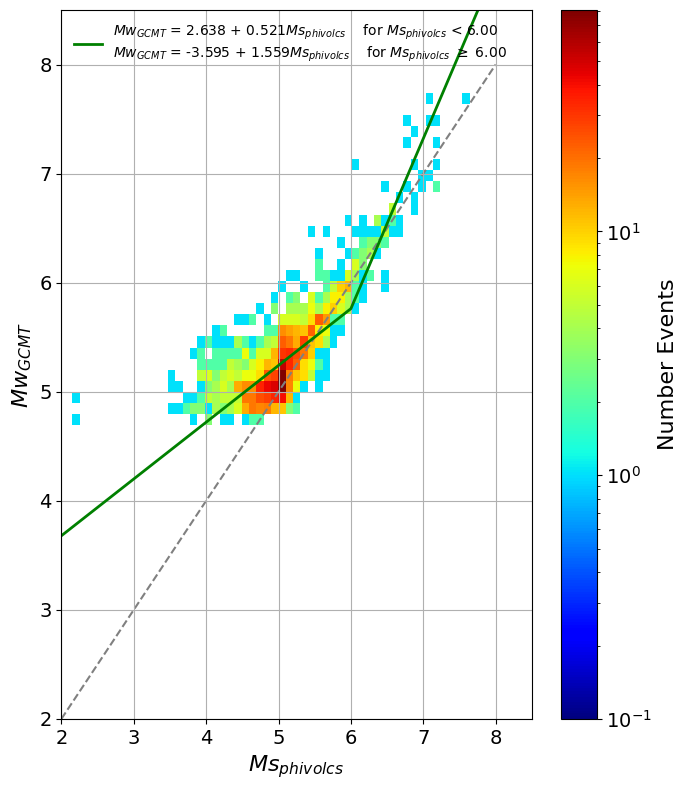

Standard Deviation - Segment 1: 0.229, Segment 2: 0.283


In [27]:
initial_guess = [1.0, 1.0, 0.0]  # [slope 1, slope 2, intercept]

linear_model = regressor.run_regression("2segmentM6.0", # Model Type
                                        initial_guess) # Initial guess of parameters
regressor.plot_model_density(False, 0)
print("Standard Deviation - Segment 1: %.3f, Segment 2: %.3f" % (regressor.standard_deviation[0],
                                                                 regressor.standard_deviation[1]))

Agency-Pairs: (phivolcs, Mw) & (GCMT, Mw) returned 218 events
Agency-Pair: (HRVD, Mw) returned no magnitudes


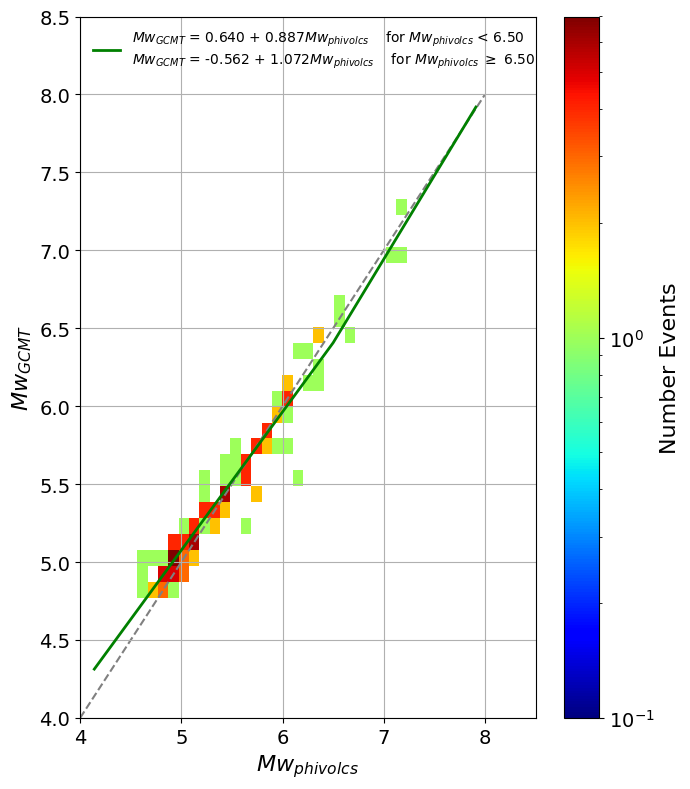

Standard Deviation - Segment 1: 0.116, Segment 2: 0.114


In [28]:
query1, cat1 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("phivolcs", "Mw"), ("GCMT", "Mw"), no_case=True)
query2, cat2 = cqt.get_agency_magnitude_pairs(db_isc_gcmt_phivolcs, ("phivolcs", "Mw"), ("HRVD", "Mw"), no_case=True)
query_phivolcs_mw = cqt.join_query_results(query1, query2)

regressor = cqt.CatalogueRegressor(query_phivolcs_mw)

initial_guess = [1.0, 1.0, 0.0]  # [slope 1, slope 2, intercept]

linear_model = regressor.run_regression("2segmentM6.5", # Model Type
                                        initial_guess) # Initial guess of parameters
regressor.plot_model_density(False, 0)
print("Standard Deviation - Segment 1: %.3f, Segment 2: %.3f" % (regressor.standard_deviation[0],
                                                                 regressor.standard_deviation[1]))